<a href="https://colab.research.google.com/github/ib-nosirov/CSCI499F21_src/blob/main/UnrolledNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


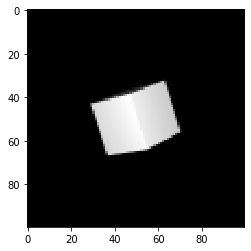

In [118]:
dataset = scipy.io.loadmat('drive/MyDrive/CSCI499F21/dataset.mat')['dataset']
plt.figure()
plt.imshow(dataset[:, :, 877], interpolation='nearest', cmap='gray')

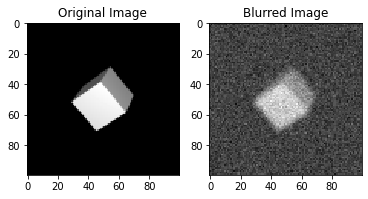

In [152]:
test_img = scipy.io.loadmat('drive/MyDrive/CSCI499F21/test.mat')['im']
weights = torch.ones(5,5) / 9
kernel = weights.view(1, 1, 5, 5)
og_img = torch.zeros(1, 1, 100, 100)
og_img[0, 0] = torch.from_numpy(test_img)
blurred_img = F.conv2d(og_img, kernel, padding=2) + torch.randn(100, 100) * 0.3
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Original Image")
ax1.imshow(og_img[0, 0], interpolation='nearest', cmap='gray')
ax2.set_title("Blurred Image")
ax2.imshow(blurred_img[0, 0], interpolation='nearest', cmap='gray')

In [120]:
#@title
class EtaLayer(nn.Module):
  """Custom unrolled layer."""
  def __init__(self, A):
    super().__init__()
    self.A = A
    self.A_T = A.transpose(1, 0)
    self.eta = nn.Parameter(torch.randn(1))

  def forward(self, x, y):
    # y has size n_batch x n_measurements
    x = x.permute(1,0)
    eta = torch.clamp(self.eta, min=0, max=100)
    Ax = self.A.matmul(x)
    y = y.permute(1,0)
    # size n_measurements x n_batch
    res = Ax - y
    x_out = x - eta * self.A_T.matmul(res)
    return x_out.permute(1, 0)


In [121]:
#@title
class WLayer(nn.Module):
  """Custom unrolled layer."""
  def __init__(self, A):
    super().__init__()
    self.A = A
    self.A_T = A.transpose(1, 0)
    self.W = nn.Parameter(torch.rand(self.A.size(dim=1),
                                     self.A.size(dim=1)))

  def forward(self, x, y):
    # y has size n_batch x n_measurements
    x = x.permute(1,0)
    W = torch.clamp(self.W, min=0, max=1)
    Ax = self.A.matmul(x)
    y = y.permute(1,0)
    # size n_measurements x n_batch
    res = Ax - y
    x_out = x - W.matmul(self.A_T.matmul(res))
    return x_out.permute(1, 0)

In [122]:
#@title
class ExtraNNLayer(nn.Module):
  """Custom unrolled layer."""
  def __init__(self, A):
    super().__init__()
    self.A = A
    self.A_T = A.transpose(1, 0)
    self.eta = nn.Parameter(torch.randn(1))
    self.W = nn.Parameter(torch.rand(self.A.size(dim=1),
                                     self.A.size(dim=1)))
    self.b = nn.Parameter(torch.rand(self.A.size(dim=1), 1))

  def forward(self, x, y):
    x = x.permute(1,0)
    eta = torch.clamp(self.eta, min=0, max=100)
    Ax = self.A.matmul(x)
    y = y.permute(1,0)
    Wx = self.W.matmul(x)
    b = self.b.permute(1,0)
    sigmoid = nn.Sigmoid()
    # size n_measurements x n_batch
    res = Ax - y
    perceptron = Wx + b
    x_out = x - eta * self.A_T.matmul(res) + sigmoid(perceptron)
    return x_out.permute(1, 0)


In [123]:
class ScalarParamNN(ModelBase):
  """Custom unrolled layer."""
  def __init__(self):
    super().__init__()
    self.eta = nn.Parameter(torch.randn(1))

  def forward(self, x, y):
    # y has size n_batch x n_measurements
    eta = torch.clamp(self.eta, min=0, max=100)
    # size n_measurements x n_batch
    res = F.conv2d(x, self.kernel, padding=2) - y
    x_out = x - eta * F.conv_transpose2d(res, self.kernel, padding=2)
    return x_out

In [147]:
#import eta_layer 
#import w_layer

class ModelBase(nn.Module):
  def __init__(self):
    super().__init__()
    self.PATH = 'drive/MyDrive/CSCI499F21/'
    weights = torch.ones(5,5) / 9
    self.kernel = weights.view(1, 1, 5, 5)
    self.model_name = None

  def forward(self, x, y):
      return null

  def etaLayer(self, A):
    return EtaLayer(A)

  def wLayer(self, A):
    return WLayer(A)

  def extraNNLayer(self, A):
    return ExtraNNLayer(A)

  def ScalarParamNN(self):
    self.model_name = 'ScalarParamNN.pth'
    return ScalarParamNN()
    
  def evaluateModel(self, og_img, blurred_img):
    self.eval()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.set_title("Original Image")
    ax1.imshow(og_img[0, 0, :, :], interpolation='nearest', cmap='gray')
    ax2.set_title("Blurred Image")
    ax2.imshow(blurred_img[0, 0], interpolation='nearest', cmap='gray')
    deblurred_img = self.forward(og_img, blurred_img)
    ax3.set_title("Deblurred Image")
    ax3.imshow(deblurred_img[0, 0].detach().numpy(), interpolation='nearest', cmap='gray')
    plt.show()
    self.train()
    #writeToFile
  def saveModel(self, model_name, epoch, cost):
    torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'cost': cost},
            self.PATH + model_name)

  def loadModel(self, model_name):
    checkpoint = torch.load(self.PATH + model_name)
    self.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
   # model.eval()
    # - or -
    self.train()


In [148]:
#import model_base
class ModelFc(ModelBase):
  """A fully-connected network with user-specifiable hyperparameters."""

  def __init__(self):
    super().__init__()
    #self.x_k1 = super().EtaLayer(A)
    #self.x_k1 = super().WLayer(A)
    #self.x_k1 = super().ExtraNNLayer(A)
    self.nn = super().ScalarParamNN()

    # Build the network layer by layer
  def forward(self, x, y):
    x_predict = self.nn(x, y)
#    for i in range(3):
#      x_predict = self.x_k1(x_predict, y) 
    return x_predict

In [149]:
"""A function that trains a neural network."""

class Trainer(nn.Module):
  """Class for training and validating neural network."""
  def __init__(self, data_train, max_epochs, batch_size):
    super(Trainer, self).__init__()
    self.train_set = DataLoader(data_train, batch_size, shuffle=True)
#    self.validate_set = DataLoader(data_validate, batch_size, shuffle=True)
    self.max_epochs = max_epochs
    self.batch_size = batch_size
    self.model = None
    self.loss = None
    self.optim = None

  def train_init(self):
    self.model = ModelFc()
    self.loss = torch.nn.MSELoss() 
    self.optim = torch.optim.SGD(self.model.parameters(), lr=1e-4)

  def learn(self, loss_val):
    self.optim.zero_grad()
    loss_val.backward()
    self.optim.step()

  def createTrainCost(self):
    running_loss = 0
    for x, y in self.train_set:
      x0 = torch.randn(x.shape[0], x.shape[1])
      x_pred = self.model(x0, y)
      loss_val = self.loss(x_pred, x)
      running_loss += loss_val
      self.learn(loss_val)
    return running_loss / len(self.train_set)

  def createConvTrainCost(self):
    running_loss = 0
    for x, y in self.train_set:
      x = x.squeeze(1)
      y = y.squeeze(1)
      x0 = torch.randn(10, 1, x.size(dim=2), x.size(dim=3))
      x_pred = self.model(x0, y)
      loss_val = self.loss(x_pred, x)
      running_loss += loss_val
      self.learn(loss_val)
    return running_loss / len(self.train_set)
    

  def train(self):
    self.train_init()
    for epoch in range(self.max_epochs):
      train_cost = self.createConvTrainCost()
      #validate_cost = self.createValidateCost()
      if(epoch % 10 == 0):
        print('epoch = #', epoch, ', train_cost = ', train_cost)
        self.model.evaluateModel(og_img, blurred_img)
        self.model.saveModel(self.model.model_name, epoch, train_cost)

epoch = # 0 , train_cost =  tensor(3.0386, grad_fn=<DivBackward0>)


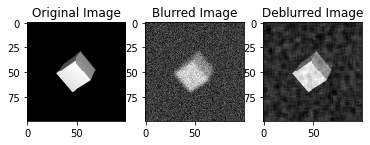

epoch = # 10 , train_cost =  tensor(0.9527, grad_fn=<DivBackward0>)


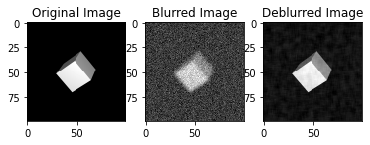

epoch = # 20 , train_cost =  tensor(0.9517, grad_fn=<DivBackward0>)


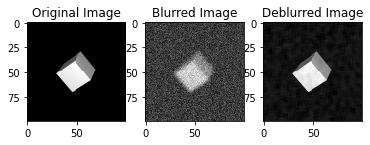

epoch = # 30 , train_cost =  tensor(0.9517, grad_fn=<DivBackward0>)


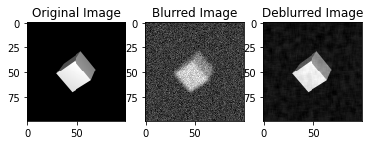

epoch = # 40 , train_cost =  tensor(0.9528, grad_fn=<DivBackward0>)


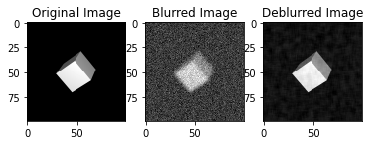

epoch = # 50 , train_cost =  tensor(0.9521, grad_fn=<DivBackward0>)


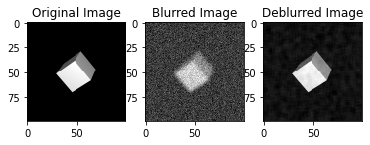

epoch = # 60 , train_cost =  tensor(0.9519, grad_fn=<DivBackward0>)


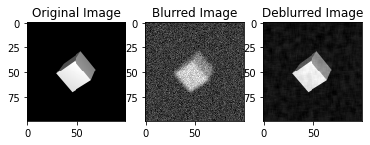

epoch = # 70 , train_cost =  tensor(0.9523, grad_fn=<DivBackward0>)


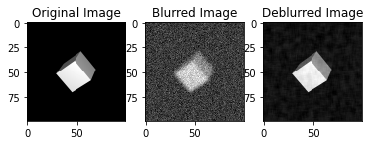

epoch = # 80 , train_cost =  tensor(0.9519, grad_fn=<DivBackward0>)


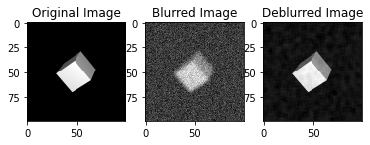

epoch = # 90 , train_cost =  tensor(0.9522, grad_fn=<DivBackward0>)


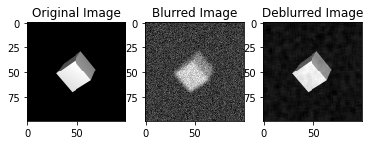

In [150]:
max_epochs = 100
batch_size = 10
weights = torch.ones(5,5) / 9
kernel = weights.view(1, 1, 5, 5)

x_train = torch.zeros(1000, 1, 1, 100, 100)
for i in range(x_train.size(dim=0)):
  x_train[i] = torch.from_numpy(dataset[:, :, i])

y_train = torch.zeros(1000, 1, 1, 100, 100)
for i in range(y_train.size(dim=0)):
  y_train[i] = F.conv2d(x_train[i], kernel, padding=2) + torch.randn(100, 100) * 0.3
  
#plt.figure()
#plt.imshow(y_train[877, 0, 0], interpolation='nearest', cmap='gray')

data_train = TensorDataset(x_train, y_train)
trainerClass = Trainer(data_train, max_epochs, batch_size)
trainerClass.train()